In this notebook I am illustrating a returns-based pairs trade between two ETFs, chosen more or less arbitrarily.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

I'll define the parameter _sdcut_ here.  As we will see below, this will determine the decision about when to enter the pairs trade.

In [2]:
sdcut = 1

We're going to look at trading the following pair:
- IGF - iShares Global Infrastructure ETF
- UGF - The Cohen & Steers Infrastructure closed end fund

(Not perfect, as UGF is a big more US-focused.)

We'll start by examining daily data from Yahoo.

In [3]:
IGF = pd.read_csv('IGF.csv', parse_dates=[0], index_col=[0])
UTF = pd.read_csv('UTF.csv', parse_dates=[0], index_col=[0])

Merging and keeping the intersection of adjusted closing prices:

In [4]:
prices = pd.DataFrame(index=IGF.index)
prices['IGF'] = IGF['Adj Close']
prices['UTF'] = UTF['Adj Close']
prices.dropna(inplace=True)
prices.head()

,IGF,UTF
Date,,
2014-01-02,33.562935,14.065733
2014-01-03,33.580406,14.051935
2014-01-06,33.475559,14.141651
2014-01-07,33.667793,14.148554
2014-01-08,33.519245,14.120949


Computing returns and dropping the first row, which will be missing:

In [5]:
returns = prices.pct_change()
returns.dropna(inplace=True)
returns.head()

,IGF,UTF
Date,,
2014-01-03,0.000521,-0.000981
2014-01-06,-0.003122,0.006385
2014-01-07,0.005743,0.000488
2014-01-08,-0.004412,-0.001951
2014-01-09,-0.002607,-0.003422


The idea of a pair trade is to buy security A and short sell security B when A has performed poorly relative to B.  If the two securities were similar, the poor relative performance of A should be reversed in the future, which happens either by A performing well or by B performing poorly.  Either way, a long-A/short-B portfolio will make money.

The return differential is what we are interested in.  We will use it as our trading signal.  It is also the rate of return on a long-UTF/short-IGF portfolio.

In [6]:
returns['diff'] = returns['UTF'] - returns['IGF']

We want to know if the differential is "large."  One way to do this is to compare it within the distribution of past values, for example by measuring it relative to a 250-day moving SD.

We'll have to drop the first 250 days of the sample since we won't have a rolling SD for them:

In [7]:
returns['rollSD'] = returns['diff'].rolling(250).std()
returns.dropna(inplace=True)

In [8]:
returns.describe()

,IGF,UTF,diff,rollSD
count,913.000000,913.000000,913.000000,913.000000
mean,0.000150,0.000394,0.000245,0.007224
std,0.008263,0.009140,0.007187,0.000889
min,-0.055269,-0.048320,-0.034636,0.004987
25%,-0.004389,-0.004012,-0.003855,0.006660
50%,0.000459,0.001052,0.000312,0.007213
75%,0.004979,0.005253,0.004595,0.007914
max,0.031722,0.038187,0.053882,0.009352


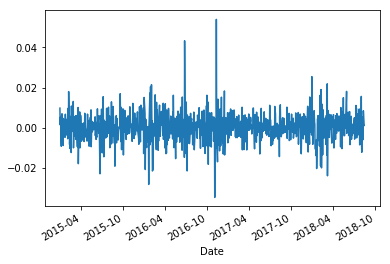

In [9]:
returns['diff'].plot()
plt.show()

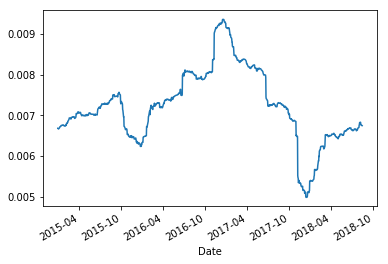

In [10]:
returns['rollSD'].plot()
plt.show()

Let's consider a simply trading rule:  Buy an amount proportional to minus the return differential.  The proportionality is set by .5 times the rolling SD.  

This means that if _diff_ is _sdcut_ SDs above zero, we will put a -1 weight in long-UTF/short-IGF.  If _diff_ is _sdcut_ SDs below zero, our weight will be +1:

In [11]:
returns['weight'] = 0
returns.loc[(returns['diff']/returns['rollSD']).shift(1) > sdcut,  'weight'] = -1
returns.loc[(returns['diff']/returns['rollSD']).shift(1) < -sdcut, 'weight'] =  1

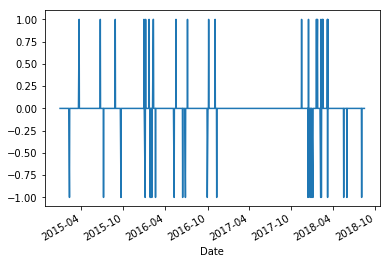

In [12]:
returns['weight'].plot()
plt.show()

The return on our long/short portfolio is equal to our portfolio weight times the long/short differential:

In [13]:
returns['longshort']=returns['weight']*returns['diff']

In [14]:
rstats = returns.describe()
print(rstats)

              IGF         UTF        diff      rollSD      weight   longshort
count  913.000000  913.000000  913.000000  913.000000  913.000000  913.000000
mean     0.000150    0.000394    0.000245    0.007224   -0.001095    0.000107
std      0.008263    0.009140    0.007187    0.000889    0.222128    0.002028
min     -0.055269   -0.048320   -0.034636    0.004987   -1.000000   -0.020789
25%     -0.004389   -0.004012   -0.003855    0.006660    0.000000   -0.000000
50%      0.000459    0.001052    0.000312    0.007213    0.000000   -0.000000
75%      0.004979    0.005253    0.004595    0.007914    0.000000   -0.000000
max      0.031722    0.038187    0.053882    0.009352    1.000000    0.023881


At first glance, this looks great.  We earn almost 5 bps per day with just .42% volatility.  This is a huge annualized Sharpe!

The question is whether this is realistic.  What do we need to take into account?

In [15]:
active=returns.loc[returns['weight']!=0]

In [16]:
astats = active.describe()
print(astats)

             IGF        UTF       diff     rollSD     weight  longshort
count  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000
mean   -0.000961  -0.002861  -0.001900   0.006686  -0.022222   0.002168
std     0.011326   0.014750   0.009044   0.000968   1.011050   0.008982
min    -0.028924  -0.047891  -0.023881   0.004987  -1.000000  -0.020789
25%    -0.006055  -0.010282  -0.006837   0.005991  -1.000000  -0.003717
50%     0.000465  -0.002097  -0.002753   0.006711  -1.000000   0.003269
75%     0.005462   0.007579   0.003834   0.007247   1.000000   0.007017
max     0.019649   0.023015   0.021850   0.009042   1.000000   0.023881


In [17]:
daily_sharpe = rstats.loc['mean','longshort'] / rstats.loc['std','longshort']
print(daily_sharpe)

0.0526875038984


In [18]:
active_sharpe = astats.loc['mean','longshort'] / astats.loc['std','longshort']
print(active_sharpe)

0.241356162975
